In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Mengambil Data
df=pd.read_csv('/content/drive/MyDrive/Machinelearning/vehicles.csv')
df=pd.DataFrame(df)
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [ ]:
#Melihat jumlah baris dan kolom
df.shape 

(426880, 26)

In [ ]:
#Menyeleksi Data
df2 = df.iloc[:-400000,:]
df2.shape

(26880, 26)

In [ ]:
#Reindexing DataFrame, price di kolom terakhir
df2= df2.reindex(columns=['id', 'url', 'region', 'region_url', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long','posting_date','price'])

# Menghapus kolom yang tidak diperlukan

In [ ]:
df2=df2.drop(columns=['url','region_url','VIN','image_url','description','county','state','posting_date'])
df2.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,7222695916,prescott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000
1,7218891961,fayetteville,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11900
2,7221797935,florida keys,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000
3,7222270760,worcester / central MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500
4,7210384030,greensboro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4900


# Dealing with missing values

In [ ]:
#Melihat jumlah data yang null
df2.isnull().sum()

id                  0
region              0
year              167
manufacturer     1186
model             389
condition       11039
cylinders       10936
fuel              184
odometer          313
title_status      429
transmission      105
drive            7919
size            19724
type             5924
paint_color      7315
lat               119
long              119
price               0
dtype: int64

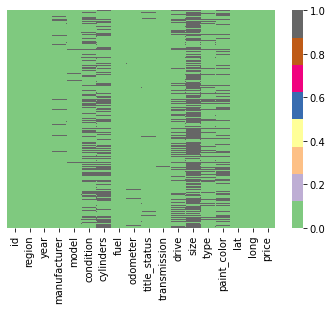

In [ ]:
#heatmap to identify nulll values using graph
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [ ]:
#define numeric variable and categorical variable to work separatly on them
num_col=['year','odometer','lat','long']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

# Estimating better iterative imputer method

In [ ]:
check_imputer=df2.copy()
check_imputer=check_imputer.drop(columns=['id'])

#object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

100%|██████████| 12/12 [00:00<00:00, 75.44it/s]


In [ ]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [ ]:
# Estimate the score on the entire dataset by filling missing values by 4 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


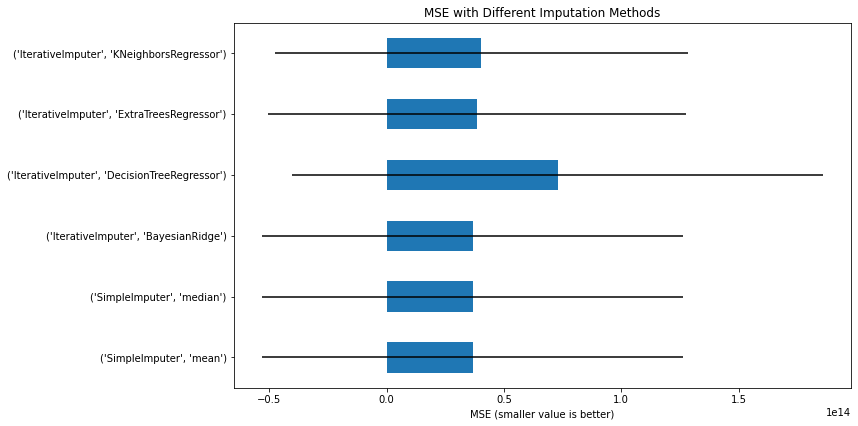

In [ ]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.show()

# Mengisi Missing Numerical Value

In [ ]:
df2.isnull().sum()[num_col]

year        167
odometer    313
lat         119
long        119
dtype: int64

In [ ]:
data_num=df2[num_col]
imputer_num=IterativeImputer(estimators[0]) #estimators[0] = Bayesian Regressor
impute_data=imputer_num.fit_transform(data_num)
df2[num_col]=impute_data

In [ ]:
df2.isnull().sum()[num_col]

year        0
odometer    0
lat         0
long        0
dtype: int64

# Mengisi Categorical Value

In [ ]:
df2.isnull().sum()[cat_cols]  

region              0
manufacturer     1186
model             389
condition       11039
cylinders       10936
fuel              184
title_status      429
transmission      105
drive            7919
size            19724
type             5924
paint_color      7315
dtype: int64

In [ ]:
data_cat=df2[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
df2[cat_cols]=data_cat  

In [ ]:
df2.isnull().sum()[cat_cols]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64

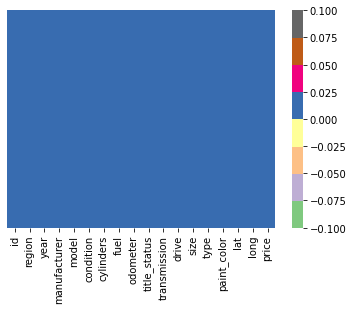

In [ ]:
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

#Outliers

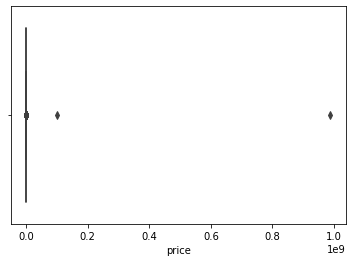

In [ ]:
sns.boxplot(x=df2['price'])

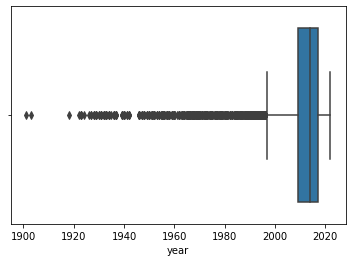

In [ ]:
sns.boxplot(x=df2['year'])

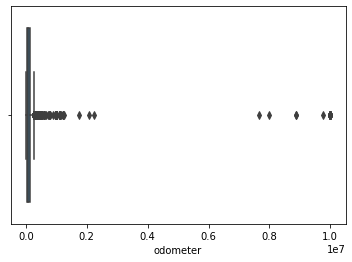

In [ ]:
sns.boxplot(x=df2['odometer'])

In [ ]:
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR=Q3-Q1
df3=df2[~((df2<(Q1-1.5*IQR))|(df2>(Q3+1.5*IQR))).any(axis=1)]

In [ ]:
df3.shape

(21346, 18)

In [ ]:
df3.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
27,7316814884,auburn,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,4wd,full-size,pickup,white,32.590,-85.4800,33590
28,7316814758,auburn,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,4wd,full-size,pickup,blue,32.590,-85.4800,22590
29,7316814989,auburn,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,4wd,full-size,pickup,red,32.590,-85.4800,39590
30,7316743432,auburn,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,4wd,full-size,pickup,red,32.590,-85.4800,30990
31,7316356412,auburn,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,full-size,truck,black,32.592,-85.5189,15000


In [ ]:
print("Shape before process=",df2.shape)
print("Shape After process=",df3.shape)
diff=df2.shape[0]-df3.shape[0]
print("Total {} rows and {} cols removed".format(diff,df2.shape[1]-df3.shape[1]))

Shape before process= (26880, 18)
Shape After process= (21346, 18)
Total 5534 rows and 0 cols removed


#Data Visualisasi

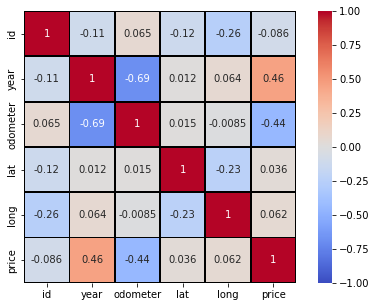

In [ ]:
#Visualisasi Heatmap untuk melihat korelasi setiap features
fig=plt.gcf()
fig.set_size_inches(8,5)
fig=sns.heatmap(df3.corr(),annot=True,cmap='coolwarm',linewidths=1,linecolor='k',square=True,mask=False,vmin=-1,vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)

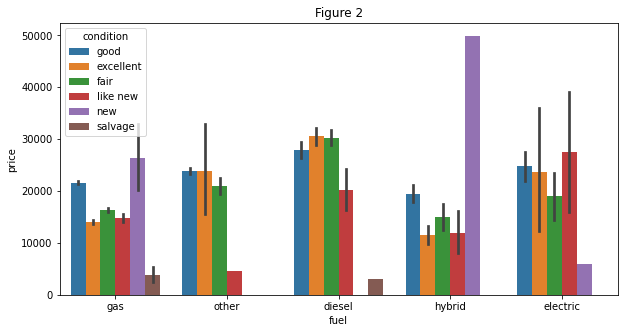

In [ ]:
#harga mobil dari masing-masing bahan bakar bergantung pada kondisi mobil tersebut.
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='price',hue='condition',data=df3)
plt.title('Figure 2')
plt.show()

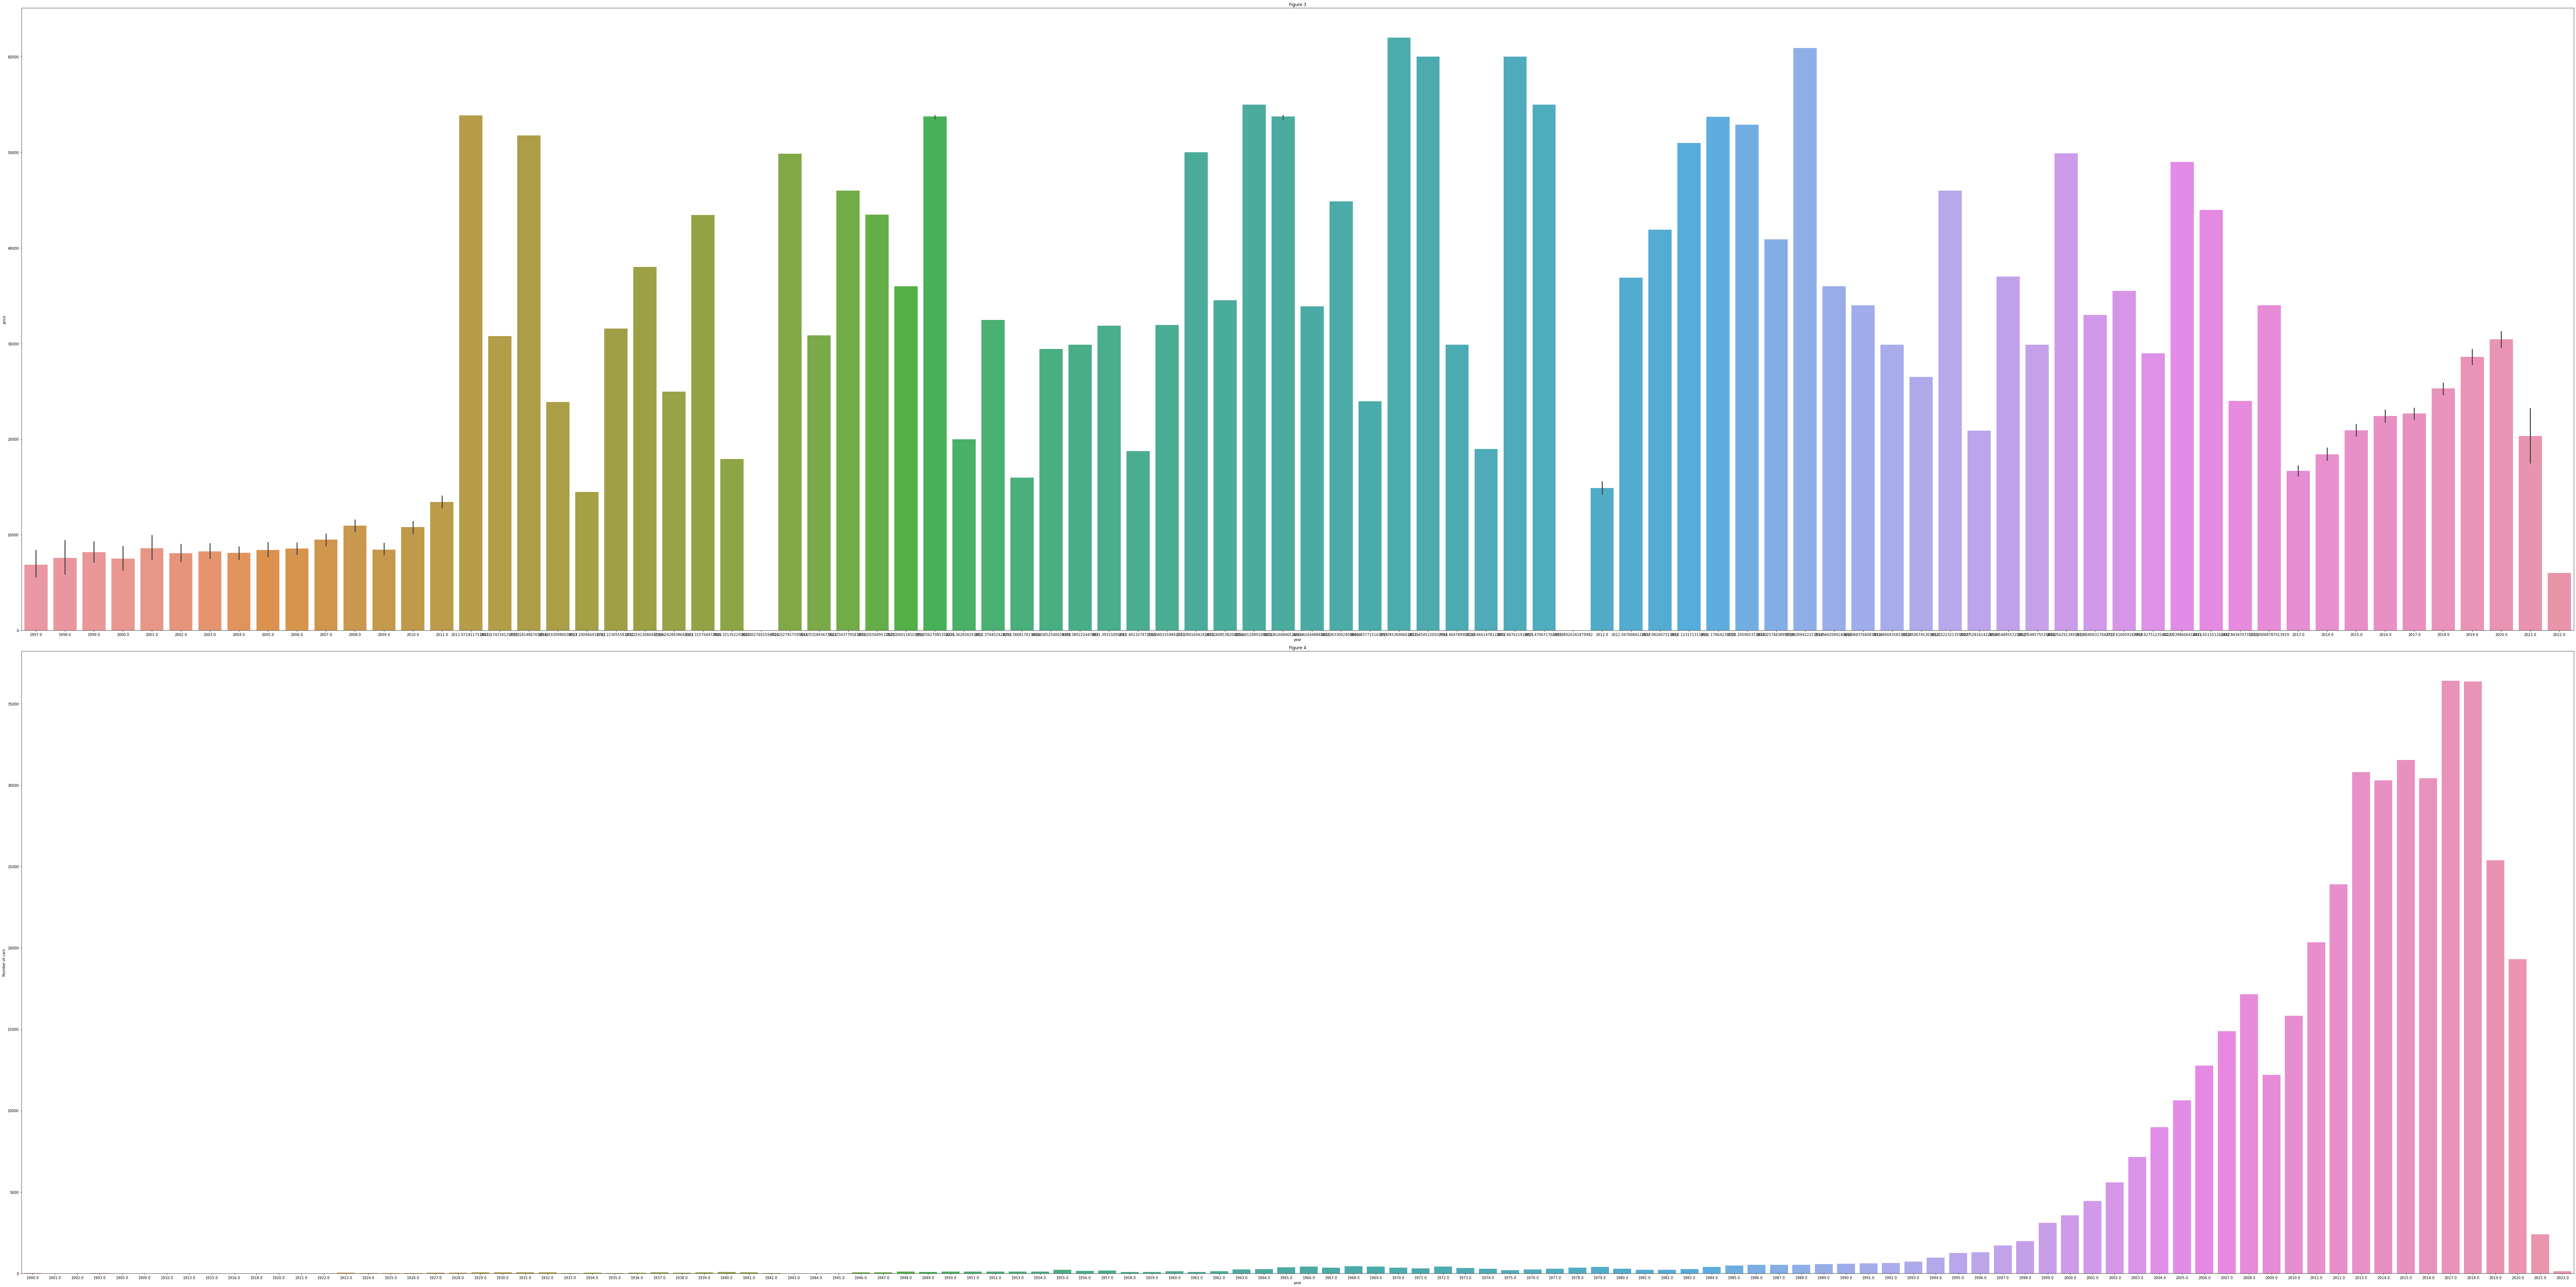

In [ ]:
#Melihat perkembangan harga per tahun dan jumlah mobil pertahun
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(100,50)
sns.barplot(x='year',y='price',data=df3,ax=axs[0])
sns.barplot(df.groupby('year').count()['price'].index,df.groupby('year').count()['price'].values,ax=axs[1])
axs[0].set_title('Figure 3')
axs[1].set_title('Figure 4')
axs[1].set_ylabel('Number of cars')
plt.tight_layout()
plt.show()

# Transforming categorical columns values into integer values

In [ ]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split


#libraries for models
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Metransformasikan Category values menjadi Integer
le=preprocessing.LabelEncoder()
df3[cat_cols]=df3[cat_cols].apply(le.fit_transform)

In [ ]:
df4= df3.copy()
df4.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
27,7316814884,1,2014.0,11,3504,2,6,2,57923.0,0,2,0,1,8,10,32.590,-85.4800,33590
28,7316814758,1,2010.0,6,3566,2,6,2,71229.0,0,2,0,1,8,1,32.590,-85.4800,22590
29,7316814989,1,2020.0,6,3578,2,6,2,19160.0,0,2,0,1,8,8,32.590,-85.4800,39590
30,7316743432,1,2017.0,34,4115,2,6,2,41124.0,0,2,0,1,8,8,32.590,-85.4800,30990
31,7316356412,1,2013.0,10,1811,0,5,2,128000.0,0,0,2,1,10,0,32.592,-85.5189,15000


In [ ]:
#Melihat kembali type data
df4.dtypes

id                int64
region            int64
year            float64
manufacturer      int64
model             int64
condition         int64
cylinders         int64
fuel              int64
odometer        float64
title_status      int64
transmission      int64
drive             int64
size              int64
type              int64
paint_color       int64
lat             float64
long            float64
price             int64
dtype: object

In [ ]:
#scaling numerical data

norm = StandardScaler()
df4['price'] = np.log(df4['price'])
df4['odometer'] = norm.fit_transform(np.array(df4['odometer']).reshape(-1,1))
df4['year'] = norm.fit_transform(np.array(df4['year']).reshape(-1,1))
df4['model'] = norm.fit_transform(np.array(df4['model']).reshape(-1,1))

#scaling target variable
q1,q3=(df4['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
df4=df4[(df4.price>=o1) & (df4.price<=o2)]

df4['region'] = norm.fit_transform(np.array(df4['region']).reshape(-1,1))
df4['lat'] = norm.fit_transform(np.array(df4['lat']).reshape(-1,1))
df4['long'] = norm.fit_transform(np.array(df4['long']).reshape(-1,1))

In [ ]:
#function to split dataset int training and test
def trainingData(df4,n):
    X = df4.iloc[:,n]
    y = df4.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df4,list(range(len(list(df4.columns))-1)))

In [ ]:
#some of models will predict neg values so this function will remove that values
def remove_neg(y_test,y_pred):
    ind=[index for index in range(len(y_pred)) if(y_pred[index]>0)]
    y_pred=y_pred[ind]
    y_test=y_test[ind]
    y_pred[y_pred<0]
    return (y_test,y_pred)

#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])  

In [ ]:
#model implementation and fitting data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

In [ ]:
#model evaluation
y_test_1,y_pred_1=remove_neg(y_test,y_pred)
r8_xg=result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 0.0009609472565723692
Root MSLE : 0.030999149287881583
R2 Score : 0.8215495236027628 or 82.155%


In [ ]:
accu['XGBoost Regressor']=r8_xg
accu

,XGBoost Regressor
MSLE,0.000961
Root MSLE,0.030999
R2 Score,0.821550
Accuracy(%),82.155000


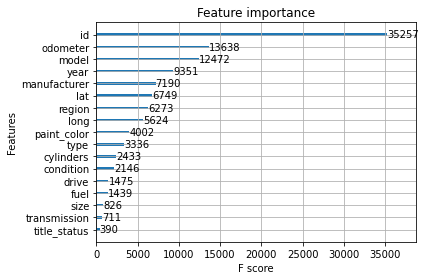

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.tight_layout()
plt.show();

#Prediksi

In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle

In [ ]:
df3.drop(['id','region','model','title_status','lat','long'],axis=1,inplace=True)
df3.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,price
27,2014.0,11,2,6,2,57923.0,2,0,1,8,10,33590
28,2010.0,6,2,6,2,71229.0,2,0,1,8,1,22590
29,2020.0,6,2,6,2,19160.0,2,0,1,8,8,39590
30,2017.0,34,2,6,2,41124.0,2,0,1,8,8,30990
31,2013.0,10,0,5,2,128000.0,0,2,1,10,0,15000


In [ ]:
norm = StandardScaler()

norm.fit(df3[['year','odometer']])
standardvalues=norm.transform(df3[['year','odometer']])

df3['year']=standardvalues[:,:1].flatten()
df3['odometer']=standardvalues[:,1:].flatten()

pickle.dump(norm, open('StandardScaler.sav', 'wb'))

df3['price'] = np.log(df3['price'])
#scaling target variable
q1,q3=(df3['price'].quantile([0.25,0.75]))
o1=q1-1.5*(q3-q1)
o2=q3+1.5*(q3-q1)
df3=df3[(df3.price>=o1) & (df3.price<=o2)]

In [ ]:
X=df3.iloc[:,:-1]
y=df3['price']

xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg2.fit(X,y)
pickle.dump(xg_reg2, open('XGBoostDeploy.sav', 'wb'))

In [ ]:
standardscaler= pickle.load(open('StandardScaler.sav', 'rb'))
mymodel = pickle.load(open('XGBoostDeploy.sav', 'rb'))

In [ ]:
year_odometer=pd.DataFrame(data=[[2022.0,30000.0]],columns=['year','odometer'])
x=standardscaler.transform(year_odometer[['year','odometer']]).flatten()

In [ ]:
test=pd.DataFrame(data=[[x[0],22,2,2,1,x[1],]],columns=X.columns)
test

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
0,1.469954,21,1,3,1,-1.304646,1,1,1,8,1


In [ ]:
pred=mymodel.predict(test)
price=np.exp(pred[0])
print(price)

25050.016
